# Univariate Case

In [2]:
import math
import random
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
#import tensorflow as tf

# Exact form of posterior and gradients

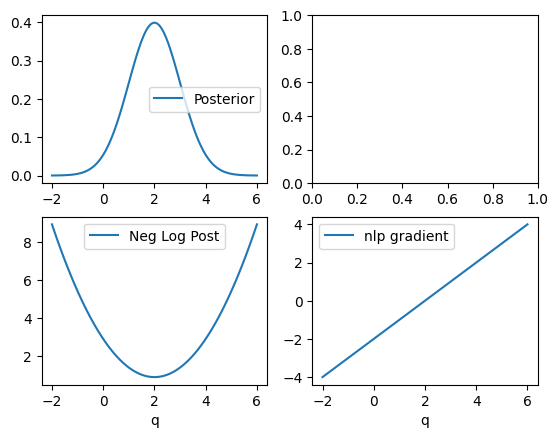

In [9]:

class NormalPosterior():

    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma

    def posterior(self, q):   
        post = math.exp(-((q-self.mu)**2)/(2*self.sigma**2))# + math.exp(-((q-mu2)**2)/(2*sigma))
        post = post/(self.sigma*math.sqrt(2*math.pi))
        return post

    def negative_log_posterior(self, q):
        #return (q-self.mu)**2/(2*self.sigma**2)
        return -math.log(self.posterior(q))

    def gradient_nlp(self, q):
        return (q-self.mu)/self.sigma**2

    def plot(self, linspace=None):

        if linspace is None:
            linspace = np.linspace(self.mu-4*self.sigma, self.mu+4*self.sigma, 100)

        y_post = [self.posterior(q) for q in linspace]
        y_nlp = [self.negative_log_posterior(q) for q in linspace]
        y_grad = [self.gradient_nlp(q) for q in linspace]

        fig, axs = plt.subplots(2,2)
        
        axs[0][0].plot(linspace, y_post, label='Posterior')
        axs[0][0].legend()
        axs[1][0].plot(linspace, y_nlp, label='Neg Log Post')
        axs[1][0].set_xlabel('q')
        axs[1][0].legend()
        axs[1][1].plot(linspace, y_grad, label='nlp gradient')
        axs[1][1].set_xlabel('q')
        axs[1][1].legend()

norm_post = NormalPosterior(2, 1)
norm_post.plot()

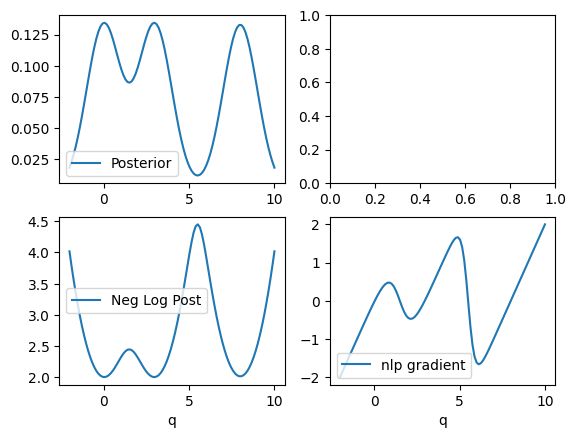

In [102]:

class ThreePeaks():

    def __init__(self):
        #self.mu = mu
        #self.sigma = sigma
        self.mu1 = 0
        self.mu2 = 3
        self.mu3 = 8
        self.sigma = 1

    def posterior(self, q):   
        post = math.exp(-((q-self.mu1)**2)/(2*self.sigma**2))
        post += math.exp(-((q-self.mu2)**2)/(2*self.sigma**2))
        post += math.exp(-((q-self.mu3)**2)/(2*self.sigma**2))
        post = post/(self.sigma*math.sqrt(2*math.pi))
        post = post/3
        return post

    def negative_log_posterior(self, q):
        #return (q-self.mu)**2/(2*self.sigma**2)
        return -math.log(self.posterior(q))

    def gradient_nlp(self, q):
        numerator = (self.mu1-q)*math.exp(-((q-self.mu1)**2)/(2*self.sigma**2)) + \
                (self.mu2-q)*math.exp(-((q-self.mu2)**2)/(2*self.sigma**2)) + \
                (self.mu3-q)*math.exp(-((q-self.mu3)**2)/(2*self.sigma**2))
        denominator = self.sigma**2*\
            (math.exp(-((q-self.mu1)**2)/(2*self.sigma**2)) + \
            math.exp(-((q-self.mu2)**2)/(2*self.sigma**2)) + \
            math.exp(-((q-self.mu3)**2)/(2*self.sigma**2)))

        nlp_grad = -numerator/denominator
        return nlp_grad
        

    def plot(self, linspace=None):

        if linspace is None:
            linspace = np.linspace(-2, 10, 100)

        y_post = [self.posterior(q) for q in linspace]
        y_nlp = [self.negative_log_posterior(q) for q in linspace]
        y_grad = [self.gradient_nlp(q) for q in linspace]

        fig, axs = plt.subplots(2,2)
        
        axs[0][0].plot(linspace, y_post, label='Posterior')
        axs[0][0].legend()
        axs[1][0].plot(linspace, y_nlp, label='Neg Log Post')
        axs[1][0].set_xlabel('q')
        axs[1][0].legend()
        axs[1][1].plot(linspace, y_grad, label='nlp gradient')
        axs[1][1].set_xlabel('q')
        axs[1][1].legend()

norm_post = ThreePeaks()
norm_post.plot()

In [103]:

class HMCLeapFrog:
    """
    Sources:
    - https://people.duke.edu/~ccc14/sta-663-2018/notebooks/S10E_HMC.html
    - https://www.youtube.com/watch?v=Byr9JVBI9cU&ab_channel=JSBUCLA
    - https://www.youtube.com/watch?v=a-wydhEuAm0&ab_channel=BenLambert
    - https://mc-stan.org/docs/2_21/reference-manual/hamiltonian-monte-carlo.html
    - https://hedibert.org/wp-content/uploads/2021/02/hmc-example.html
    - https://towardsdatascience.com/python-hamiltonian-monte-carlo-from-scratch-955dba96a42d
 

    p ~ N(0,T), T = 1 is commonly used - "This corresponds to the correct case when we want to sample from posterior"

    U(q) = -log[p(q)p(D|q)] = -log[p(q)] - log[p(D|q)]    (last term likelihood, D data)
    => dU(q)/dq = d(-log[p(q)])/dq - 0 ??
    Note: U is -log(unnormalizied posterior?)

    K(p) = p^2/(2mass)
    => dK/dp = p*mass_invers. with mass = 1: dK/dp = p
    """


    def __init__(self, posterior, initial_position:float=0.0, epochs:int=10, path_len:float=1.0, step_size:float=0.2, T:float=1):
        
        self.posterior = posterior#NormalPosterior(2,1)
        self.epochs = epochs
        self.initial_position = initial_position

        # leap frog settings
        self.path_len = path_len
        self.step_size = step_size

        self.T = T

        # Storing
        self.samples = []
        #self.pp = []
        self.orbits_momentums = []
        self.orbits_samples = []
        self.epochs_accepted = []

        #self.N_rejected = 0
        #self.N_accepted = 0

    def run(self):
        
        q0 = self.initial_position
        self.samples.append(q0)
        
        for epoch in range(self.epochs):
            # Step 2: compute  gradient and leap frog
            p0 = np.random.normal(0, self.T)
            
            dUdq = self.posterior.gradient_nlp
            q1, p1, orbit_qq, orbit_pp = leap_frog(dUdq, q0, p0, self.path_len, self.step_size)
            self.orbits_momentums.append(orbit_pp)
            self.orbits_samples.append(orbit_qq)

            # Step 3: Metropolis (Hastings)
            """
            ln(u) < U0 + K0 - U1 - K1

            source: https://mc-stan.org/docs/2_21/reference-manual/hamiltonian-monte-carlo.html
            source: https://www.youtube.com/watch?v=Byr9JVBI9cU&ab_channel=JSBUCLA
            """
            K0 = p0**2/2 #2*mass
            K1 = p1**2/2
            U0 = self.posterior.negative_log_posterior(q0)
            U1 = self.posterior.negative_log_posterior(q1)  

            if math.log(np.random.uniform(0,1)) < (K0 + U0) - (K1 + U1): 
                q0 = q1
                self.samples.append(q0)
                self.epochs_accepted.append(True)
            else:
                q0 = q0
                self.epochs_accepted.append(False)

        return self.samples



def leap_frog(gradient, q:float, p:float, path_len:float, step_size:float):
    """
    Run one path in the Leap frog algorithm

    - The leapfrog algorithm begins by drawing a fresh momentum term independently of the parameter values q or previous momentum value.
    - It then alternates half-step updates of the momentum and full-step updates of the position.
    Source: https://mc-stan.org/docs/2_21/reference-manual/hamiltonian-monte-carlo.html
    
    gradient: derivate of potential energy wrt position.
    q: position
    p: momentum 
    """
    n_steps = round(path_len/step_size)

    m = 1 #mass
    orbit_qq = [q]
    orbit_pp = [p]
    # Note this part can be done more efficiently, looping only over full steps. And running a halfstep before and after the loop.
    for _ in range(n_steps):
        # Half step momentum
        #p = p - step_size/2*dUdq
        p = p - step_size/2*gradient(q)
        # Full-step 
        q = q + step_size*p/m # step_size*dK/dp, but dK/dp = p/m
        # Half step momentum
        #p = p - step_size/2*dUdq
        p = p - step_size/2*gradient(q)
        orbit_qq.append(q)
        orbit_pp.append(p)

    # record also the flipped momentum 
    #orbit_qq.append(q)
    #orbit_pp.append(-p)
    # Flip momentum at the end: Leap Frog. TODO explain. This has no impact?
    return q, -p, orbit_qq, orbit_pp

    


### Normal distr

In [104]:
hmc = HMCLeapFrog(NormalPosterior(2,1), initial_position=0,epochs=100000, path_len=1.5, step_size=0.1)
samples = hmc.run()
print('n accepted', np.sum(hmc.epochs_accepted))

n accepted 99927


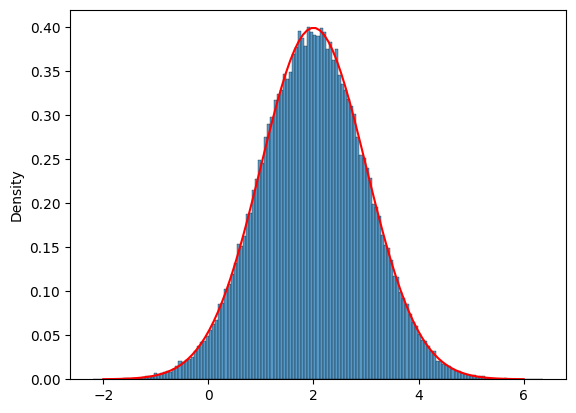

In [105]:
sns.histplot(samples, stat='density')

#post = NormalPosterior(2,1)
x = np.linspace(-2,6, 100)
y = [hmc.posterior.posterior(i) for i in x]
plt.plot(x,y, color='red')


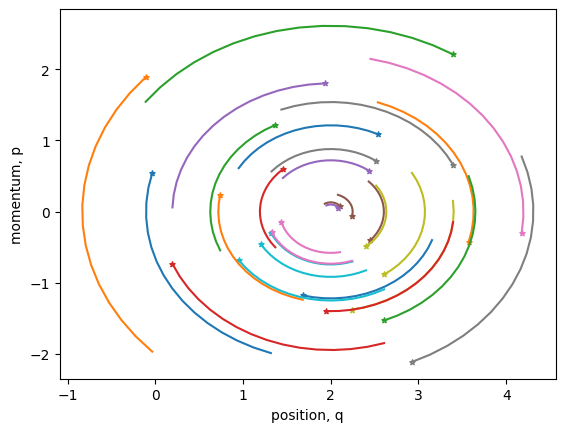

In [106]:

n_start = 300
N = 30
for j in range(N):
    if hmc.epochs_accepted[n_start+j]:
        plt.plot(hmc.orbits_samples[n_start+j], hmc.orbits_momentums[n_start+j])
        plt.scatter(hmc.orbits_samples[n_start+j][-1], hmc.orbits_momentums[n_start+j][-1], s=15, marker='*')
    plt.xlabel('position, q')
    plt.ylabel('momentum, p')

## Three Peak Normal dist

In [112]:
hmc = HMCLeapFrog(ThreePeaks(), initial_position=0,epochs=100000, path_len=1.3, step_size=0.1)
samples = hmc.run()
print('n accepted', np.sum(hmc.epochs_accepted))

n accepted 99944


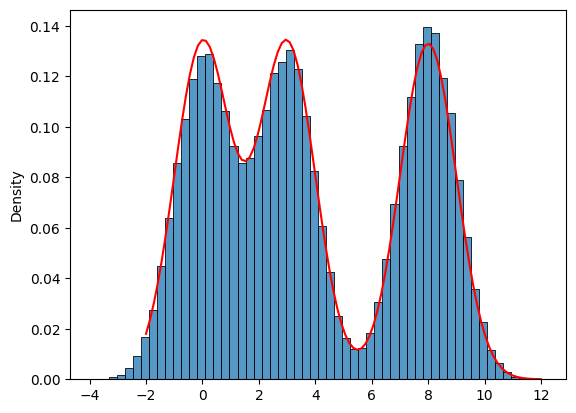

In [113]:
sns.histplot(samples, stat='density')

#post = NormalPosterior(2,1)
x = np.linspace(-2,12, 100)
y = [hmc.posterior.posterior(i) for i in x]
plt.plot(x,y, color='red')


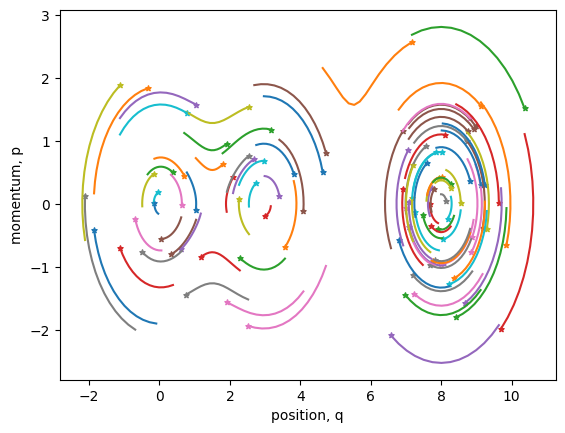

In [115]:

n_start = 300
N = 100
for j in range(N):
    if hmc.epochs_accepted[n_start+j]:
        plt.plot(hmc.orbits_samples[n_start+j], hmc.orbits_momentums[n_start+j])
        plt.scatter(hmc.orbits_samples[n_start+j][-1], hmc.orbits_momentums[n_start+j][-1], s=15, marker='*')
    plt.xlabel('position, q')
    plt.ylabel('momentum, p')